# NASA Global Data

-----

## Processed Data Research

A notebook for researching the processed NASA (and Weather Underground) data from the `src/process_data.py` script.

In [1]:
processed_data_dir = '../data/processed'
media_dir = '../media'
figsize_width = 12
figsize_height = 8
output_dpi = 72

In [2]:
# Imports
import os
import pickle
import numpy as np
import pandas as pd
from sklearn import linear_model
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# Variables
default_fig_size = (figsize_width, figsize_height)
colors = ['#2d758c', '#cf4917', '#f9ac3d', '#758c33']

def load_data(filename):
    """Helper function to load data"""
    with open(os.path.join(processed_data_dir, filename), 'rb') as fin:
        ret = pickle.load(fin)
    return ret

# - Load NASA Data
temp_anomaly = load_data('nasa_temperature_anomaly.pkl')
sea_level = load_data('nasa_sea_level.pkl')

# - Load Wunderground Data
region_df = load_data('region_data.pkl')
region_yearly_df = load_data('region_yearly_data.pkl')

In [4]:
# Agggregate average max wind speed data by year
mws_index = region_yearly_df.loc[:, ['Start Date']].set_index('Start Date').index
mws_yearly = region_yearly_df.groupby(mws_index.year, axis=0).mean().loc[:, 'Max Winds']

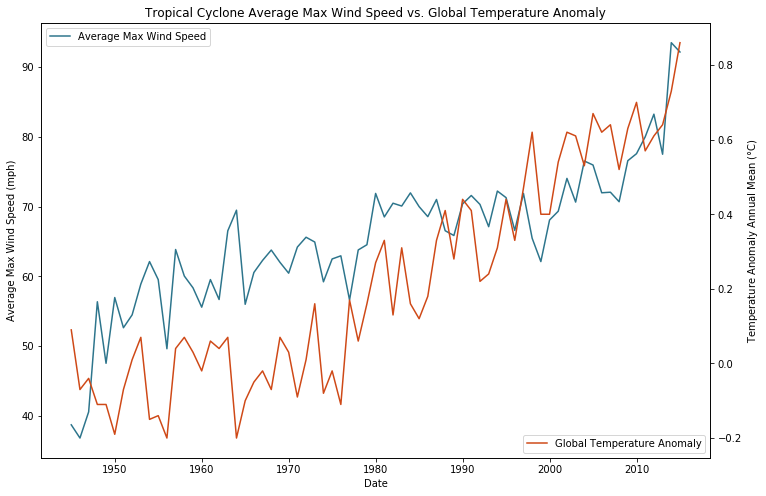

In [5]:
# Compare Max Wind Speed with Temperature
plt_start = 1945
plt_end = 2015

# -- Plot
fig, ax = plt.subplots(figsize=default_fig_size)

mws_yearly.loc[plt_start:plt_end].plot(ax=ax, color=colors[0], 
                                       label='Average Max Wind Speed')

ax2 = ax.twinx()
temp_anomaly.loc[plt_start:plt_end, 'Annual Mean'].plot(ax=ax2, color=colors[1], 
                                                        label='Global Temperature Anomaly')

ax.set_title('Tropical Cyclone Average Max Wind Speed vs. Global Temperature Anomaly')
ax.set_xlabel('Date')
ax.set_ylabel('Average Max Wind Speed (mph)')
ax2.set_ylabel(r'Temperature Anomaly Annual Mean ($\degree$C)')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')

fig.savefig(os.path.join(media_dir, 'avg_max_wind_global_vs_temp_anomaly.png'),
            dpi=output_dpi)
plt.show();

In [6]:
# - Correlation (absolute)
test_corr = pd.concat([mws_yearly, temp_anomaly], axis=1).loc[plt_start:plt_end].corr()
test_corr.columns.name = 'Correlation'
test_corr

Correlation,Max Winds,Annual Mean,Lowness Smoothing
Max Winds,1.000000,0.758480,0.784242
Annual Mean,0.758480,1.000000,0.958712
Lowness Smoothing,0.784242,0.958712,1.000000


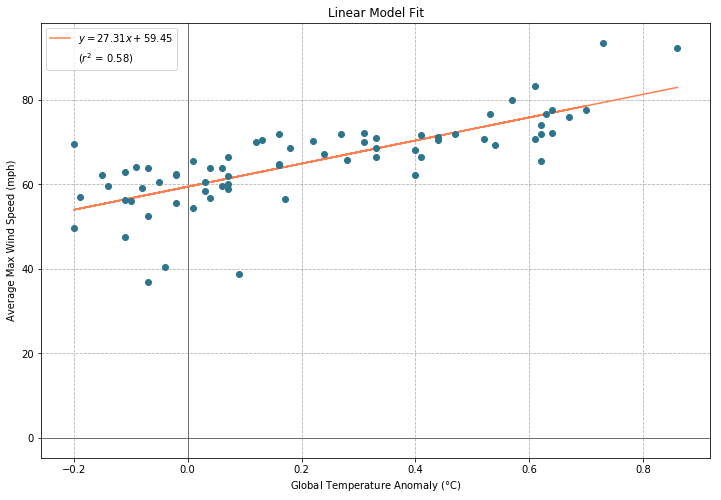

In [7]:
# - Linear model
# -- Normalize Series
x_act = temp_anomaly.loc[plt_start:plt_end, 'Annual Mean'].values.flatten()
y_act = mws_yearly.loc[plt_start:plt_end].values.flatten()

x_act = x_act.reshape(-1, 1)

# -- Fit Model
model = linear_model.LinearRegression().fit(x_act, y_act)
formula = r'$y = {:.2f}x + {:.2f}$'.format(model.coef_[0], model.intercept_)

y_pred = (model.coef_ * x_act) + model.intercept_
r2 = model.score(x_act, y_act)

# -- Plot
fig, ax = plt.subplots(figsize=default_fig_size)

ax.scatter(x_act.flatten(), y_act, color=colors[0], zorder=3)
ax.plot(x_act, y_pred, color='coral', label=formula, zorder=2)

handles, labels = ax.get_legend_handles_labels()
handles += [matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none',
                                         visible=False)]
labels += ['($r^2$ = {:.2f})'.format(r2)]
ax.legend(handles, labels)

ax.grid(True, color='grey', alpha=0.6, linestyle='--', zorder=0)
ax.axvline(0, color='black', alpha=0.8, linewidth=0.75, zorder=1)
ax.axhline(0, color='black', alpha=0.8, linewidth=0.75, zorder=1)

ax.set_title('Linear Model Fit')
ax.set_ylabel('Average Max Wind Speed (mph)')
ax.set_xlabel(r'Global Temperature Anomaly ($\degree$C)')

fig.savefig(os.path.join(media_dir, 'simple_linear_model_fit.png'), dpi=output_dpi)
plt.show();